<a href="https://colab.research.google.com/github/andrebododea/TinyML/blob/master/tinyml_hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create And Convert A TensorFlow Model
This notebook lays out just a basic "hello world" machine learning project for an embedded environment, using Keras and TensorFlow Lite.


The goal here is  to train a model to take a value, x, and predict its sine, y. This is obviously just a toy example, but it will then be run on an embedded device. The end result will be that the sine wave will run smoothly from -1 to 1 and back, making it perfect for oscillating an LED on the microcontroller. The target platform will be an Arduino Nano 33 BLE Sense, running an ARM Cortex-M4 processor

This project is based on the following [notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb) from the TensorFlow examples repo. Everything has been hand-coded and reproduced manually for learning purposes.

# Import dependencies


In [0]:
# TensorFlow is an open source ML library
import tensorflow as tf
# NumPy is a math library
import numpy as np
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# math is Python's math library
import math

# Generate data

The following code will generate a set of random `x` values, calculate their sine values, and display them on a graph:

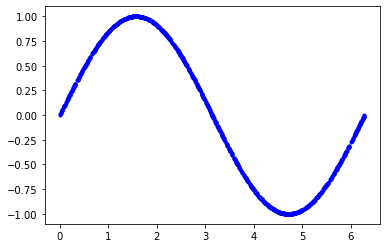

In [7]:
# Define the number of sample datapoints
SAMPLES = 1000

# Set a seed value for the random number generator
np.random.seed(1337)

# Generate a uniformly distributed set of random numbers in the range from  
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots
plt.plot(x_values, y_values, 'b.')
plt.show()

# Adding noise
The data generated is perfect....almost too perfect. We're going to want to add some noise to it in order to simulate real-world, messy data. 

So now add some random noise to each value, then draw a new graph.

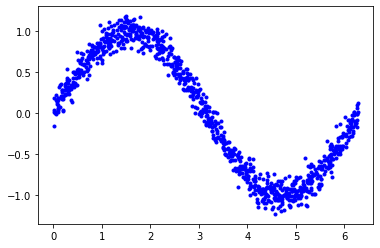

In [8]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Now plot the data
plt.plot(x_values, y_values, 'b.')
plt.show()

# Split our data
We now have a noisy dataset that approximates "real world data". We'll use this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation), and then after training (referred to as testing). 

So we'll need to set aside some data to use for evaluation and testing - 20% and 20% respectively. The remaining 60% is used to train the model. This is a typical split for training models. 

The following code splits the data then plots each set as a different color. 

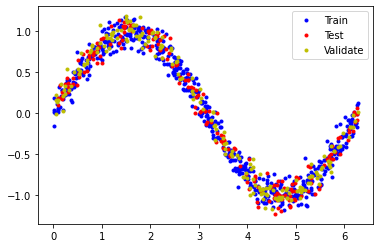

In [10]:
# Calculate the indeces for the training section of the data, and the test section.
# Validation will be from 0 to TRAIN_SPLIT, then TRAIN_SPLIT to TEST_SPLIT will be 
# the training data. Then the rest is testing data.
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts
# The second argument to np.split is an array of indices where the data will be 
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

# Plot the data in each partition in different colors
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

# Design a model
We're going to build a model that takes an input value (in this case `x`) and use it to predict a numeric output value (the sine of `x`). This  type of problem is called a _regression_.

To achieve this, we'll create a simple neural network. It will use _layers of neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 16 neurones. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value. 

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained.

In [0]:
# We'll use Keras to create a simple model architecture
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

So what's going on here?

First, we're creating a Sequential model using Keras. This just means a model in which each layer of neurons is stacked on top of the next. Then we define two layers.

## First Layer

The first layer has a single input - our `x` value - and 16 neurons. It's a Dense layer, also known as a fully connected layer, meaning the input will be fed into every single one of its neurons during inference, when we're making predictions. 

The _activation function_ is a mathematical function used to shape the output of the neuron. In our network, we're using an activation function called _rectified lineaer unit_ or _ReLU_ for short. ReLU returns whichever is the larger value: its input, or zero. If its input value is negative, ReLU returns zero. If its input value is above zero, ReLU returns it unchanged. 

Without an activation function, the neuron's output would always be a linear function of its input. This would mean that the network could model only linear relationships in which the ratio between x and y remains the same across the entire range of values. This would prevent a network from modeling our sine wave, because a sine wave is nonlinear. And since ReLU is nonlinear, it allows multiple layers of neurons to join forces and model complex nonlinear relationships, in which the y value doesn't increase by the same amount for every increment of x.

## Second layer
The activation numbers from our first layer will be fed as inputs to our second layer. Because this layer is a single neuron, it will receive 16 inputs, one for each of the neurons in the previous layer. Its purpose is to combine all of the activations from the previous layer into a single output value. Since this is our output layer, we don't specify an activation function - we just want the raw result.

Because this neuron has multiple inputs, it has a corresponding weight value for each. The neuron's output is calculated by the following formula, shown in Python:
` output = sum((inputs * weights)) * bias`. The output value is obtained by multiplying each input with its corresponding weight, summing the results, and then adding in the neuron's bias. **The network's weights and biases are learned during training.** 

## Compiling
The `compile()` step in the code configures some important arguments used in the training process, and prepares the model to be trained.

The `optimizer` argument specifies the algorithm that will adjust the network to model its input during training. There are several choices, and finding the best one often comes down to experimentation. 

The `loss` argument specifies the method used during training to calculate how far the network's predictions are from reality. This method is called a _loss function_. Here, we're using `mse` or _mean squared error_. This loss function is used in the case of regressino problems, for which we're trying to predict a number.

The `metrics` argument allows us to specify some additional functions that are used to judge the performance of our model. We specify `mae` or _mean absolute error_, which is helpful for measuring the performance of a regression model. This metric will be measured during training, and we'll have access to the results after training is done. 

After compiling the model, we can use the following line to print some summary information about its architecture:

In [15]:
# Print a summary of the model's architecture
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


The table shows the layers of the network, their output shapes, and their numbers of parameters. **The size of a network - how much memory it takes up - depends mostly on its number of parameters, meaning its total number of weights and biases. This can be a useful metric when discussing model size and complexity.**


# Training our model
